# Stanford - 96 codes - Jupyter example
title             : Stanford - 96 codes - Jupyer example.nbpy [filename]
description       : Multi file - Stanford Setup
author            : Bjorn Harink                              [Original author(s) of this file]
credits           : Kurt Thorn, Huy Nguyen                    [Contributors to this file]
date              : 20170220                                  [Initial date yyyymmdd]
version update    : 20170220                                  [Last version update yyyymmdd]
version           : v0.1
usage             : This is an example file for the Bead Analysis module.
notes             : Multiple file code set for Stanford setup - Jupyter Notebook
python_version    : 2.7

# Import modules and bead analysis tools

In [1]:
# [Future imports]
# "print" function compatibility between Python 2.x and 3.x
from __future__ import print_function
# Use Python 3.x "/" for division in Pyhton 2.x
from __future__ import division

# [Modules]
# General Python
import sys
sys.path.append('../')  # Or wherever your Bead Analysis module folder is
import random
# Data structures
import numpy as np
import pandas as pd
# Image Processing
from scipy import ndimage as ndi # Imaging
from sklearn.mixture import GaussianMixture
# Project
import bead_analysis as ba

# Image display/notebook settings
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib notebook
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

Copyright 2016 - The Encoded Beads Project - ThornLab@UCSF and FordyceLab@Stanford


# Global Settings

In [2]:
# Reference image location
REF_FILES = {"Dy" : r"Y:\Data\Setup 1\Bead Reference Files\Dy_solo_20160915_3\Dy_solo_20160915_3_MMStack_Pos0.ome.tif",
             "Sm" : r"Z:\Bjorn\[Stanford]\Ref Spectra Stanford\Sm_solo_20160915_1\Sm_solo_20160915_1_MMStack_Pos0.ome.tif",
             "Tm" : r"Z:\Bjorn\[Stanford]\Ref Spectra Stanford\Tm_1_2_solo_20160915_4\Tm_1_2_solo_20160915_4_MMStack_Pos0.ome.tif",
             "Eu" : r"Z:\Bjorn\[Stanford]\Ref Spectra Stanford\Eu_solo_20160915_3\Eu_solo_20160915_3_MMStack_Pos0.ome.tif"}

TRP_FILE = r"Y:\Data\Setup 1\Bead Reference Files\20170322_W_Blank_1\20170322_W_Blank_1_MMStack_Pos0.ome.tif"

# Target file location
TARGET_FILE = r"Z:\Code Sets\20160226_DySmTm_48Codes.csv"

# General Region or interest
# slice(Y1, Y2) and slice(X1, X2) Y and X are reversed in array since rows (Y) go first and columns go second (X). Pandas includes stop element!
CROPx = slice(250, 750)
CROPy = slice(250, 750)


#########################
###   Targets/Codes   ###
"""[NOTES - Target File]
The target file contains the code ratios and are stored 
in a csv file with makeup [CeTb, Dy, Sm, Tm], e.g.:
>>> target
array([[ 0.20061,  0.08155,  0.     ,  0.65606],
       [ 0.     ,  0.08155,  0.10822,  0.     ],
       [ 0.     ,  0.08155,  0.10822,  0.19141],
       ...
"""

target = np.genfromtxt(TARGET_FILE, delimiter=',')
target = target[:, 1:4]  # Target set to Dy, Sm, Tm (no CeTb)

# Bead search and filter parameters
bead_objects = ba.FindBeads(min_r=6, max_r=9, min_dist=11, param_1=10, param_2=7, annulus_width=3, enlarge = 1)
reference_std_factor_low = 1.5
reference_std_factor_high = 2
back_std_factor = 3

# ICP settings
icp=ba.ICP(matrix_method='std', max_iter=100, tol=1e-4, outlier_pct=0.01, train=False)

# GMM settings
gmix = ba.Classify(target, tol=1e-5, min_covar=1e-7, sigma=1e-5, train=False)

# Reference Spectra

In [3]:
# Background image set file location
BACK_FILE = r"Y:\Data\Setup 1\Bead Reference Files\20170320_blank_1_MMStack_Pos0.ome.tif"

# Reference images ROI
CROPx_ref = slice(600, 1550)
CROPy_ref = slice(600, 1550)

# Background ROI
BACK_ROIx = slice(300, 700)
BACK_ROIy = slice(300, 700)

dark_noise = 99  # Camera dark noise
spec_object = ba.simp.ReferenceSpectra(files = REF_FILES, 
                                       object_channel = 'Brightfield', 
                                       channels = ['435','780'], 
                                       find_param = [14,16,10,6], 
                                       dark_noise = dark_noise)
spec_object.crop_x = CROPx_ref
spec_object.crop_y = CROPx_ref
spec_object.set_back(BACK_FILE, ['l-435','l-780'], BACK_ROIx, BACK_ROIy)
ref_data_object = spec_object.output

# Trp
name = "Tp"
print("Spectrum: %s" % name)
ref_objects_tp = ba.FindBeads(min_r=14, max_r=16, param_1=10, param_2=6)
ref_img_obj = ba.ImageSetRead(TRP_FILE)
ref_img_obj.crop_x = CROPx_ref
ref_img_obj.crop_y = CROPx_ref
ref_objects_tp.find(ref_img_obj['Brightfield'])
ref_data_tmp = spec_object.get_spectrum(dark_noise, ref_img_obj['l-435':'l-780'], ref_objects_tp.labeled_mask)
ref_data_object.spec_add(name, data=ref_data_tmp)

Spectrum Bkg: slice(300, 700, None), slice(300, 700, None)


D:\Google Drive\[UCSF]\[Software]\DEV\Encoded Beads Project\Bead Analysis\bead_analysis\data.py:235: UserWarning:

Channel names not the same or channels unchecked!



Spectrum: Eu
Number of unique segments found: 277


c:\python27\lib\site-packages\numpy\core\numeric.py:2623: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Spectrum: Tm
Number of unique segments found: 277
Spectrum: Sm
Number of unique segments found: 391
Spectrum: Dy
Number of unique segments found: 251
Spectrum: Tp
Number of unique segments found: 262


<IPython.core.display.Javascript object>


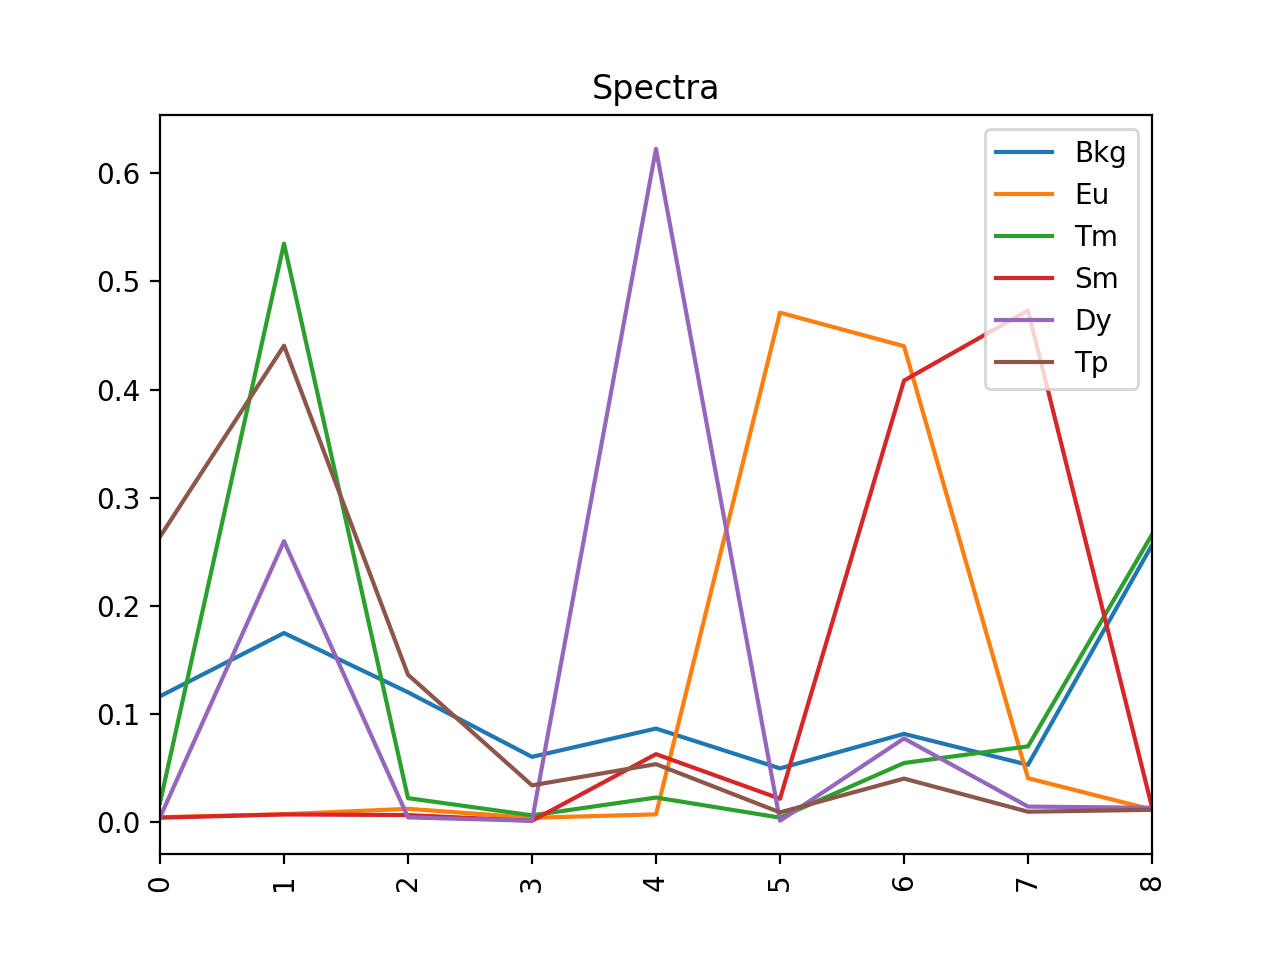

In [4]:
ref_data_object.plot()

# Load image files and detect objects
Initiated bead_set data

In [5]:
# Bead image set file location
BEAD_IMAGE_FOLDER = r"Z:\Bjorn\[Stanford]\20170102 Pre"
BEAD_IMAGE_PATTERN = "20170102_48B_20161229_Preb_*"

bead_image_files = ba.ImageSetRead.scan_path(BEAD_IMAGE_FOLDER, BEAD_IMAGE_PATTERN)
bead_image_obj = ba.ImageSetRead(bead_image_files)
bead_image_set_bf = bead_image_obj[:,'Brightfield',CROPy,CROPx]
bead_image_set_ln = bead_image_obj[:,'l-435':'l-780',CROPy,CROPx]

In [6]:
bead_set = pd.DataFrame(columns=['img', 
                                 'lbl', 
                                 'dim_x', 
                                 'dim_y', 
                                 'dim_r',
                                 'bkg',
                                 'ref',
                                 'rat_dy',
                                 'rat_sm',
                                 'rat_tm'])

labels = []
labels_annulus = []
bead_no = 0
for idx in xrange(bead_image_obj.f_size):
    bead_objects.find(bead_image_set_bf[idx])
    if bead_objects.labeled_mask is None:
        continue
    labels.append(bead_objects.labeled_mask)
    labels_annulus.append(bead_objects.labeled_annulus_mask)
    circles_dim = np.array(bead_objects.circles_dim)
    for lbl in np.arange(1, len(np.unique(labels[idx]))):
        bead_set.loc[bead_no,('img', 'lbl', 'dim_x', 'dim_y', 'dim_r')] = \
            [idx, lbl, circles_dim[lbl-1, 0], circles_dim[lbl-1, 1], circles_dim[lbl-1, 2]]
        bead_no += 1
        
print("Total number of beads found: %s" % bead_no)

Number of unique segments found: 195
Number of unique segments found: 175
Number of unique segments found: 132
Number of unique segments found: 226
Number of unique segments found: 243
Number of unique segments found: 223
Number of unique segments found: 290
Number of unique segments found: 222
Number of unique segments found: 350
Number of unique segments found: 348
Number of unique segments found: 338
Number of unique segments found: 165
Number of unique segments found: 257
Number of unique segments found: 315
Number of unique segments found: 308
Number of unique segments found: 218
Number of unique segments found: 263
Total number of beads found: 4268


# Unmix and get Ratios

In [7]:
spec_unmix = ba.SpectralUnmixing(ref_data_object)
bead_no = 0
for lbls_idx, lbls in enumerate(labels):
    spec_unmix.unmix(bead_image_set_ln[lbls_idx])

    background = spec_unmix['Bkg']  # Device background
    reference = spec_unmix['Eu']  # Internal reference: Eu
    # Ratio images
    ratio_Dy = spec_unmix['Dy'] / reference
    ratio_Sm = spec_unmix['Sm'] / reference
    ratio_Tm = spec_unmix['Tm'] / reference
    # Get ratios from images
    idx = np.arange(1, len(np.unique(lbls)))
    ratio_data = np.empty((len(idx), target[0].size))
    ratio_data[:, 0] = ndi.labeled_comprehension(ratio_Dy, lbls, idx, np.median, float, -1)
    ratio_data[:, 1] = ndi.labeled_comprehension(ratio_Sm, lbls, idx, np.median, float, -1)
    ratio_data[:, 2] = ndi.labeled_comprehension(ratio_Tm, lbls, idx, np.median, float, -1)

    background_data = ndi.labeled_comprehension(background, lbls, idx, np.median, float, -1)
    reference_data = ndi.labeled_comprehension(reference, lbls, idx, np.median, float, -1)

    for lbl in np.arange(1, len(np.unique(lbls))):
        bead_set.loc[bead_no,('rat_dy', 'rat_sm', 'rat_tm', 'bkg', 'ref')] = \
            [ratio_data[lbl-1,0], ratio_data[lbl-1,1], ratio_data[lbl-1,2], background_data[lbl-1], reference_data[lbl-1]]
        bead_no += 1

In [8]:
bead_set

img  lbl dim_x dim_y dim_r      bkg      ref      rat_dy       rat_sm  \
0      0    1   352     5     7 -6958.55  93324.9    0.425061   0.00544424   
1      0    2    95     9     8 -4266.19  85541.9  0.00749527   0.00139451   
2      0    3   109    12     8 -2644.17  82040.4  0.00616536   -0.0021489   
3      0    4   260    12     8 -4693.14  92368.4    0.965392   0.00220419   
4      0    5   372    15     8 -2962.67  76439.2     0.63776      0.12408   
5      0    6   176    20     8 -6930.15  83572.2     0.25693     0.461416   
6      0    7   245    21     7 -14606.8   138493    0.012497     0.011289   
7      0    8    46    23     8 -3978.14  70301.8    0.226882     0.689771   
8      0    9     4    25     7 -4359.85   105494  0.00506616     0.134071   
9      0   10   107    28     8 -2918.21  79095.7    0.228093     0.266159   
10     0   11   490    31     8 -4624.86  79805.7  0.00751314 -0.000713238   
11     0   12   398    33     8 -3768.71    77541    0.394029     0.260682   
12     0   13   368    39     8 -7558.34  84557.5     0.13539     0.132857   
13     0   14    27    43     7 -2571.63  90806.8    0.388544   -0.0034591   
14     0   15   146    44     8 -6178.75  88606.3    0.144985     0.710989   
15     0   16   441    47     8 -3463.12  83172.2    0.391424  0.000378153   
16     0   17   304    48     8 -5692.66  87010.2    0.136177     0.449774   
17     0   18   455    52     7 -4530.71   103141  0.00648577     0.264069   
18     0   19   136    54     8 -6365.99  86047.3    0.250074     0.279467   
19     0   20   223    56     8 -5613.18  82700.5    0.253188     0.132683   
20     0   21    18    57     8 -6225.56  80119.7      0.1303     0.132551   
21     0   22   435    57     7 -4338.06  87440.6    0.634558     0.258764   
22     0   23   127    65     8  -4894.4  90390.2  0.00541723      0.73906   
23     0   24   147    65     8 -7278.69  86402.5    0.136669     0.139036   
24     0   25   294    67     8 -3670.93  95177.7    0.232877     0.126682   
25     0   26   392    68     8 -4366.62    86651    0.113642     0.441915   
26     0   27    27    69     8 -7206.11  80970.6    0.130866     0.275066   
27     0   28   255    70     8 -4979.76    87158  0.00618519     0.737062   
28     0   29   363    71     8 -3545.75  86363.6    0.116428     0.263166   
29     0   30   488    72     8 -5875.59  92165.5  0.00480664     0.689402   
...   ..  ...   ...   ...   ...      ...      ...         ...          ...   
4238  16  234   199   453     8 -2317.46  78015.1   0.0114681     0.296053   
4239  16  235   334   455     8 -3598.28  69430.9    0.146304     0.131466   
4240  16  236   419   455     8 -3501.96  64810.6     0.69481  -0.00284094   
4241  16  237   477   458     8 -4186.76  63543.4    0.251243   0.00206281   
4242  16  238   318   461     8 -7546.64  73426.1    0.152757     0.135885   
4243  16  239   181   462     8 -3437.26    63349    0.757289  -0.00524089   
4244  16  240   299   463     8 -7703.04  79976.2    0.163773  -0.00487449   
4245  16  241   272   465     8 -3099.63  74815.3   0.0129358     0.303879   
4246  16  242   207   466     8 -2643.47  77402.7   0.0108539     0.151793   
4247  16  243   359   466     7 -5412.47  80047.4   0.0136601     0.777403   
4248  16  244    49   467     8 -6357.05  75651.3    0.142183      0.14317   
4249  16  245   379   467     8 -6178.02  69100.3     1.13069  -0.00613926   
4250  16  246   286   470     8 -2676.48  74069.3   0.0125373     0.151522   
4251  16  247   143   471     8 -6218.72    71589    0.276799     0.496798   
4252  16  248   160   472     7 -10856.2  96001.7     0.15252     0.301493   
4253  16  249   393   474     8  -2850.2  66374.9    0.253053     0.281162   
4254  16  250   173   474     8 -7703.34  72215.9    0.156724     0.300646   
4255  16  251   233   475     7  -5278.2  85863.2   0.0104074     0.781786   
4256  16  252   200   480     8 -6910.34  69050.6     0.15317     0.292529   
4257  16  253   275   479  

# Filtering

Pre filter: 4268
Post filter: 4034


<IPython.core.display.Javascript object>


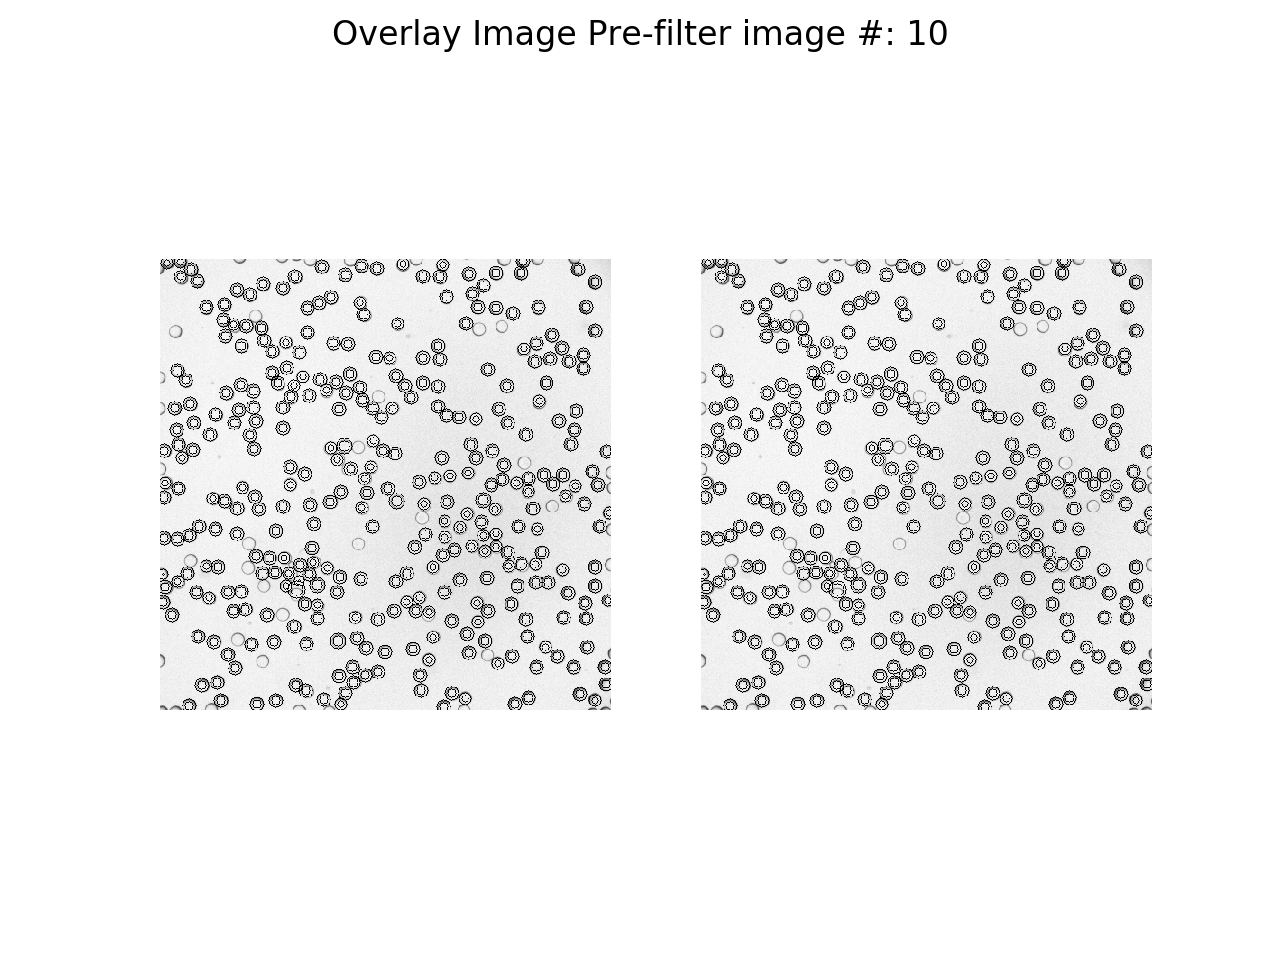

<IPython.core.display.Javascript object>


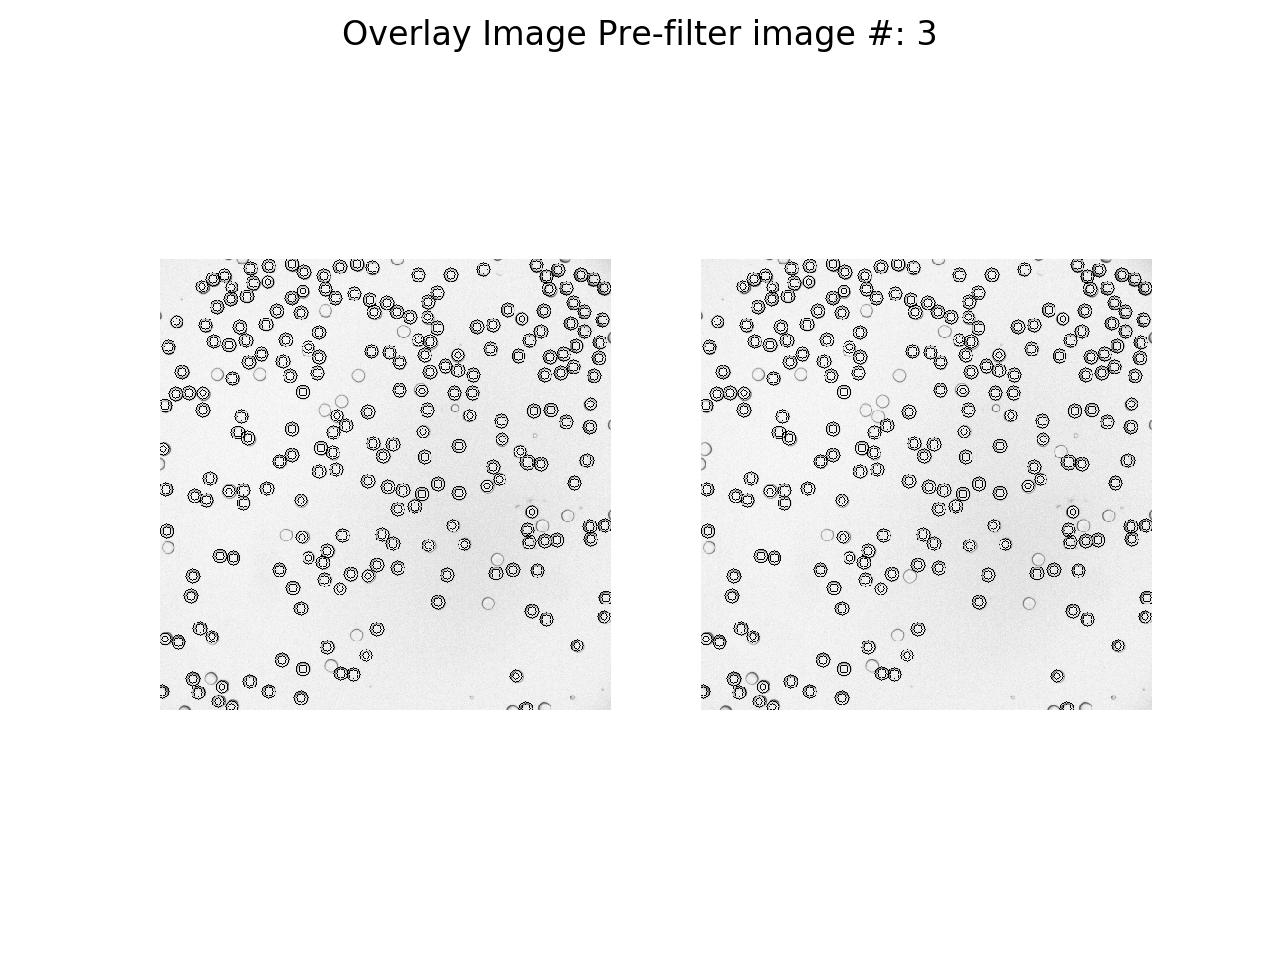

<IPython.core.display.Javascript object>


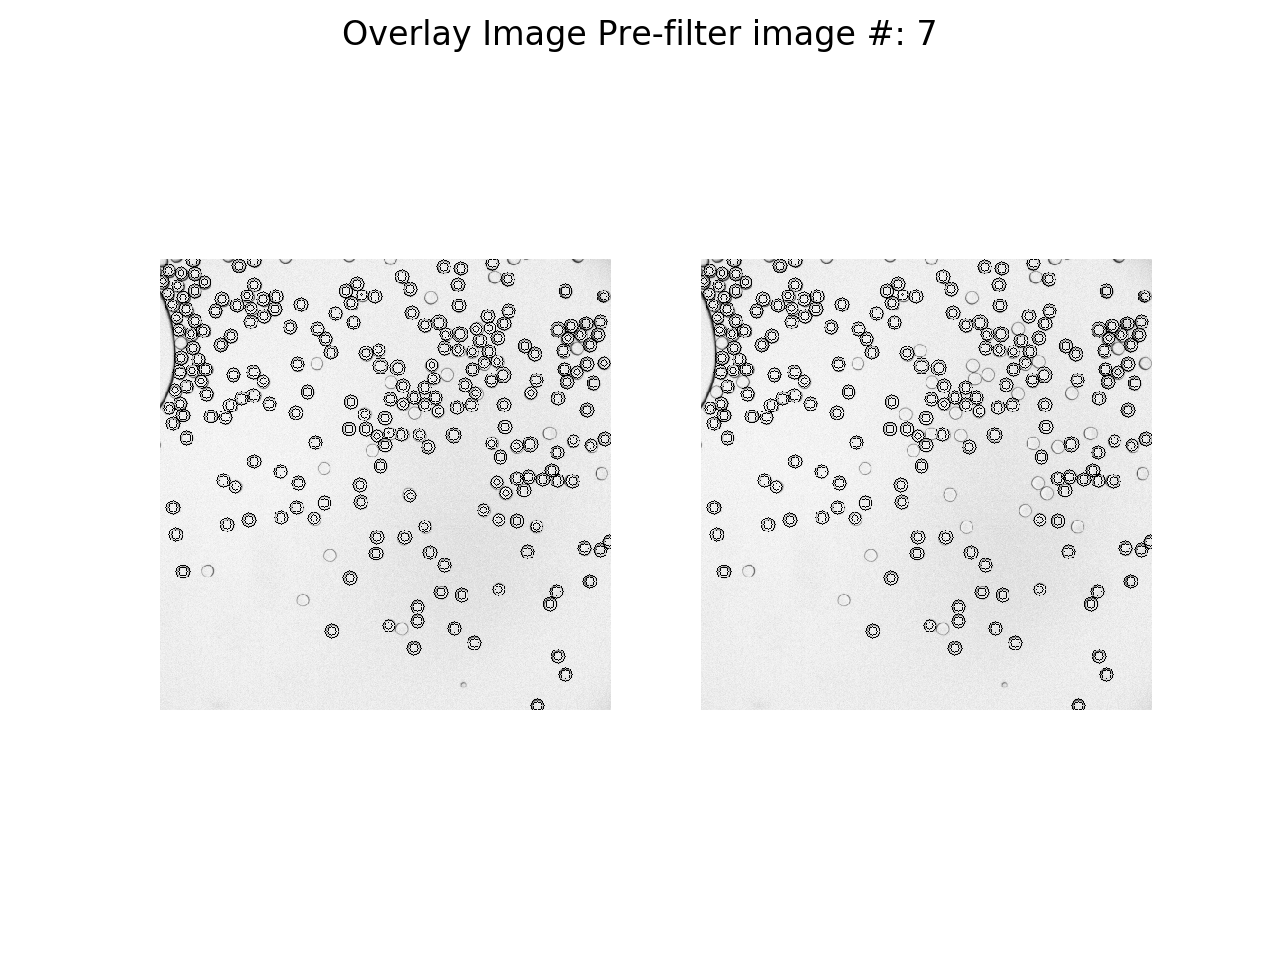

In [9]:
mask_bkg    = ( (bead_set.bkg > (bead_set.bkg.mean() - back_std_factor * bead_set.bkg.std())) &\
                (bead_set.bkg < (bead_set.bkg.mean() + back_std_factor * bead_set.bkg.std())) )
mask_ref    = ( (bead_set.ref > (bead_set.ref.mean() - reference_std_factor_low * bead_set.ref.std())) &\
                (bead_set.ref < (bead_set.ref.mean() + reference_std_factor_high * bead_set.ref.std())) )
filter_all = (mask_bkg & mask_ref)

print("Pre filter: %s" % bead_set.index.size)
print("Post filter: %s" % bead_set[filter_all].index.size)

# Pre-filter images
img_idx = []
for x in xrange(3):
    idx = random.choice(np.unique(bead_set.img))
    img_idx.append(idx)
    fig = plt.figure()
    ax = fig.add_subplot(1,2,1)
    ax.axis('off')
    fig.suptitle("Overlay Image Pre-filter image #: %s" % idx)
    ax.imshow(bead_objects.overlay_image(bead_image_set_bf[idx], 
                                          dim=bead_set.loc[(bead_set['img'] == idx), ('dim_x','dim_y','dim_r')].values,
                                          annulus=True), cmap='Greys_r')
    ax = fig.add_subplot(1,2,2)
    ax.axis('off')
    ax.imshow(bead_objects.overlay_image(bead_image_set_bf[idx], 
                                          dim=bead_set.loc[filter_all & (bead_set['img'] == idx), ('dim_x','dim_y','dim_r')].values,
                                          annulus=True), cmap='Greys_r')

# ICP

In [10]:
icp.fit(bead_set.loc[filter_all, ('rat_dy', 'rat_sm', 'rat_tm')], target)
bead_set = bead_set.join(icp.transform())
print("Tranformation matrix: ", icp.matrix)
print("Offset vector: ", icp.offset)

Delta:  0.090641777399
Delta:  0.0319092250381
Delta:  0.0162670970854
Delta:  0.000301562008562
Delta:  7.53578288067e-05
Converged after: 5
Tranformation matrix:  [[ 0.91171922  0.016883   -0.01842741]
 [-0.00937191  0.93493969 -0.03650037]
 [-0.2528177  -0.0973214   6.91287532]]
Offset vector:  [-0.01464659 -0.00674463  0.01696117]


# Classification

In [11]:
gmix.decode(bead_set.loc[filter_all, ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')])
bead_set = bead_set.join(gmix.output)
print("Number of unique codes found:", gmix.found)
print("Missing codes:", gmix.missing)

Number of unique codes found: 48
Missing codes: None


## Data inspection charts
Notes...

<IPython.core.display.Javascript object>


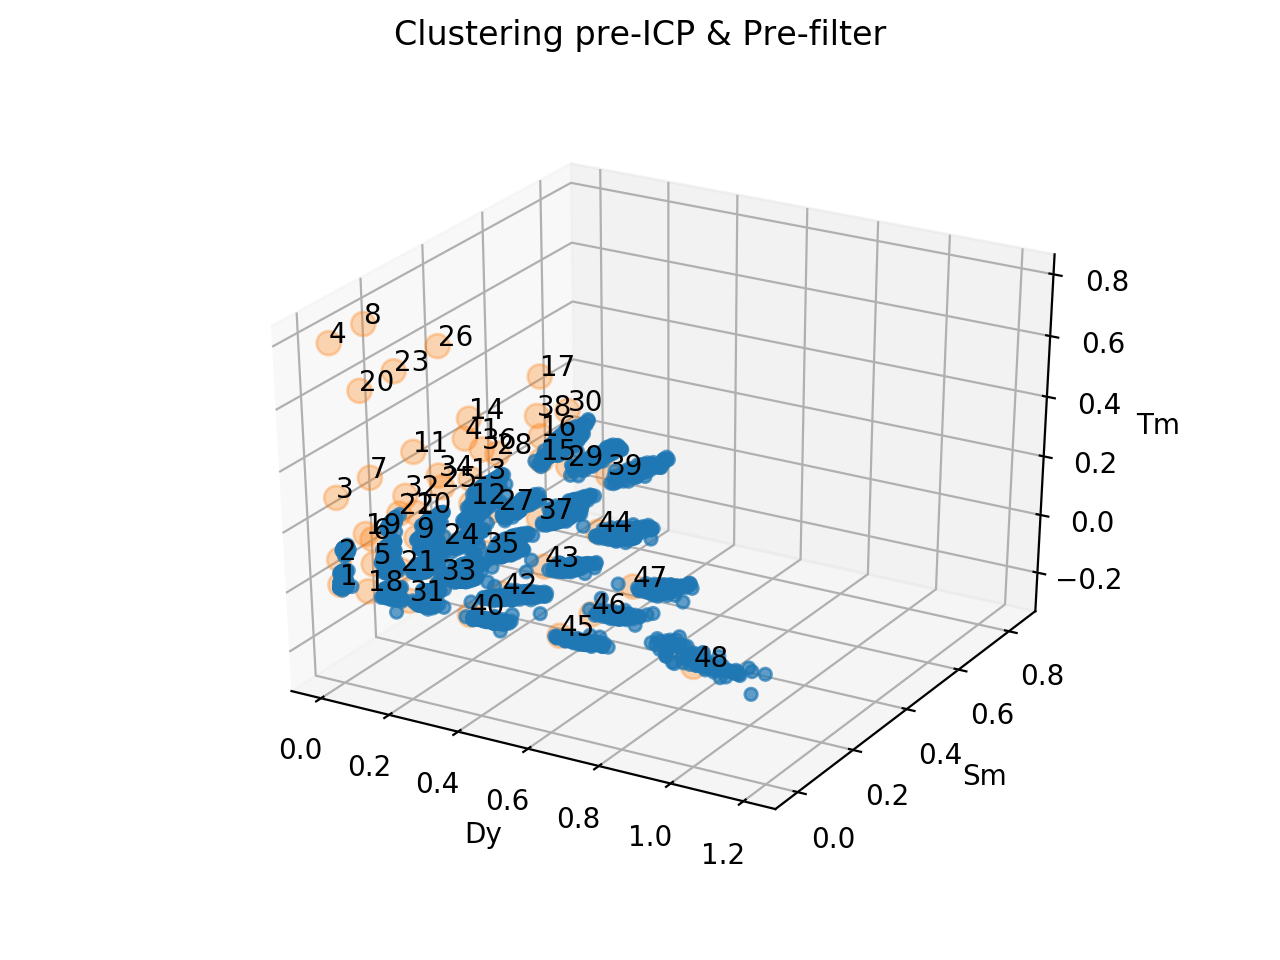

<IPython.core.display.Javascript object>


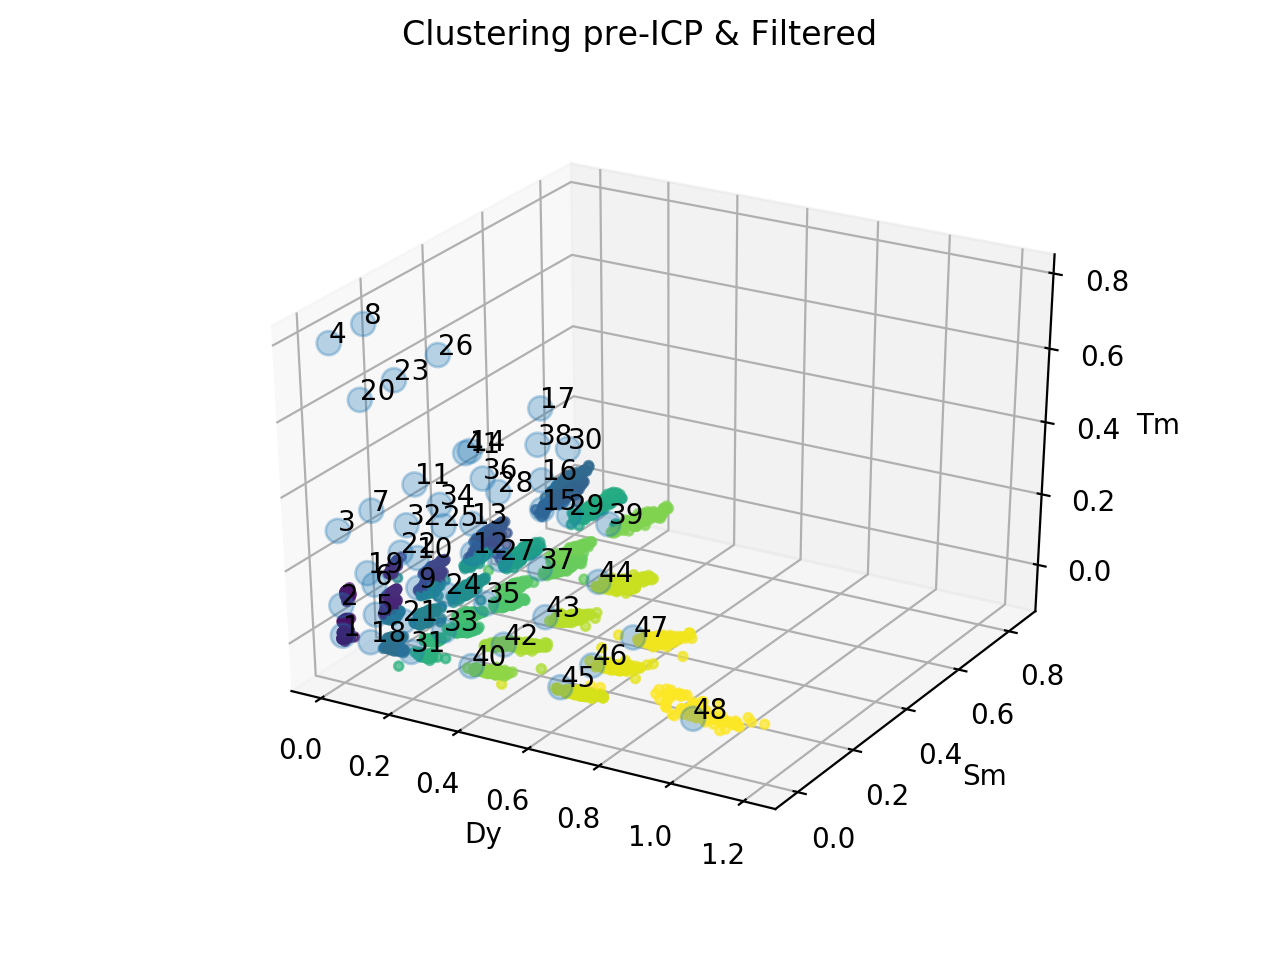

<IPython.core.display.Javascript object>


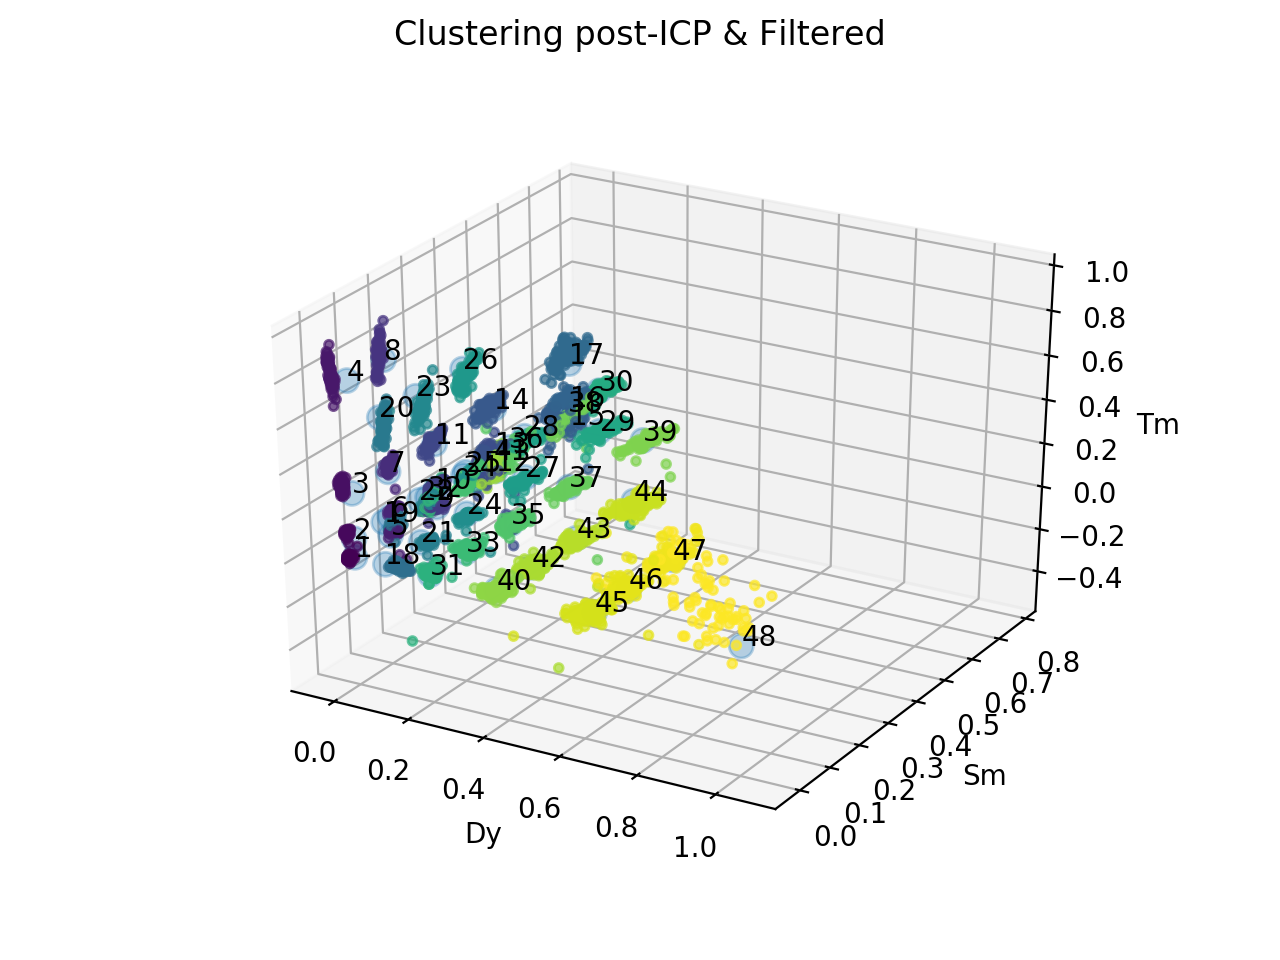

<IPython.core.display.Javascript object>


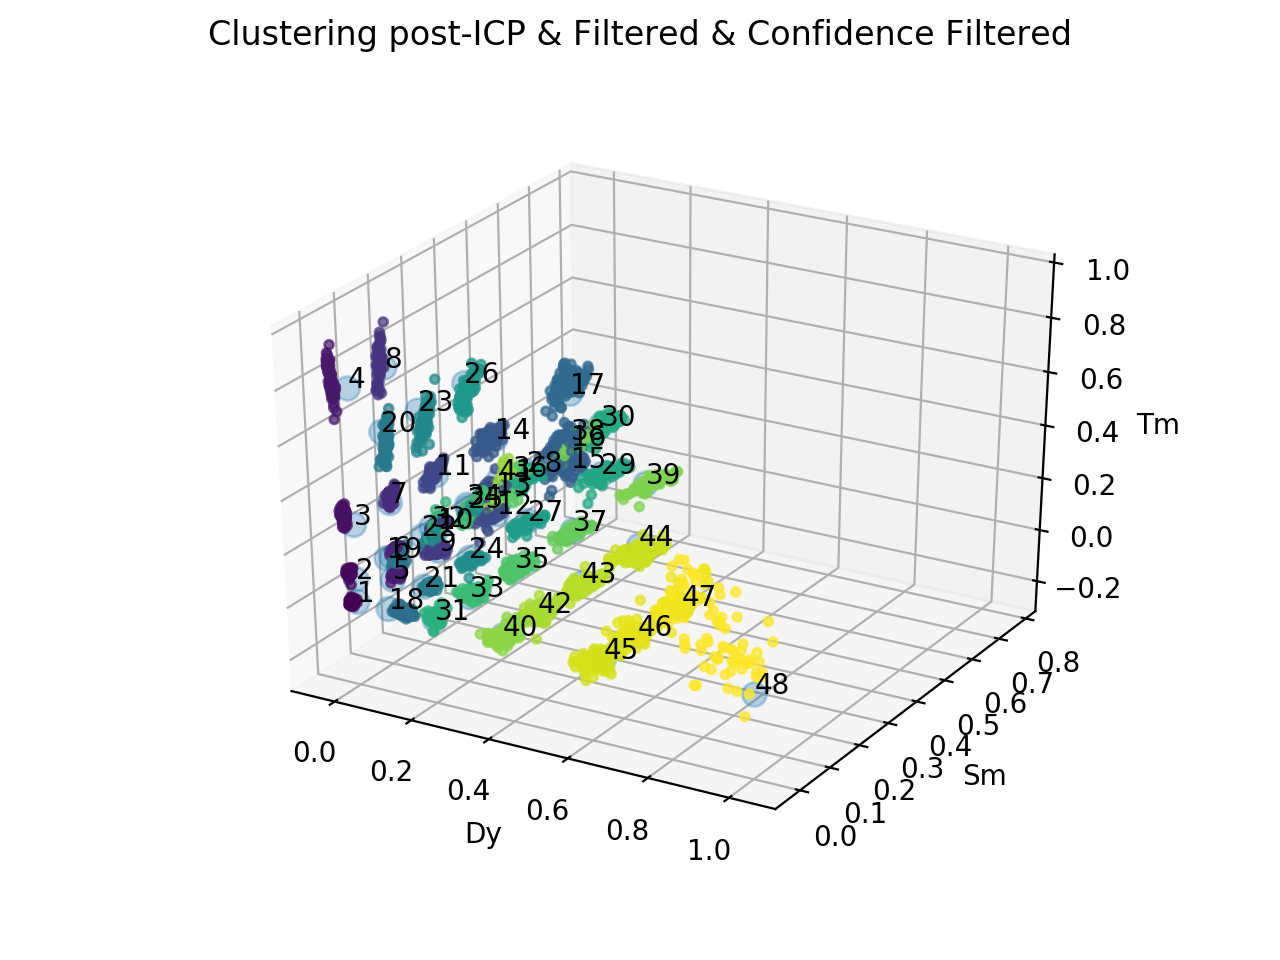

<IPython.core.display.Javascript object>


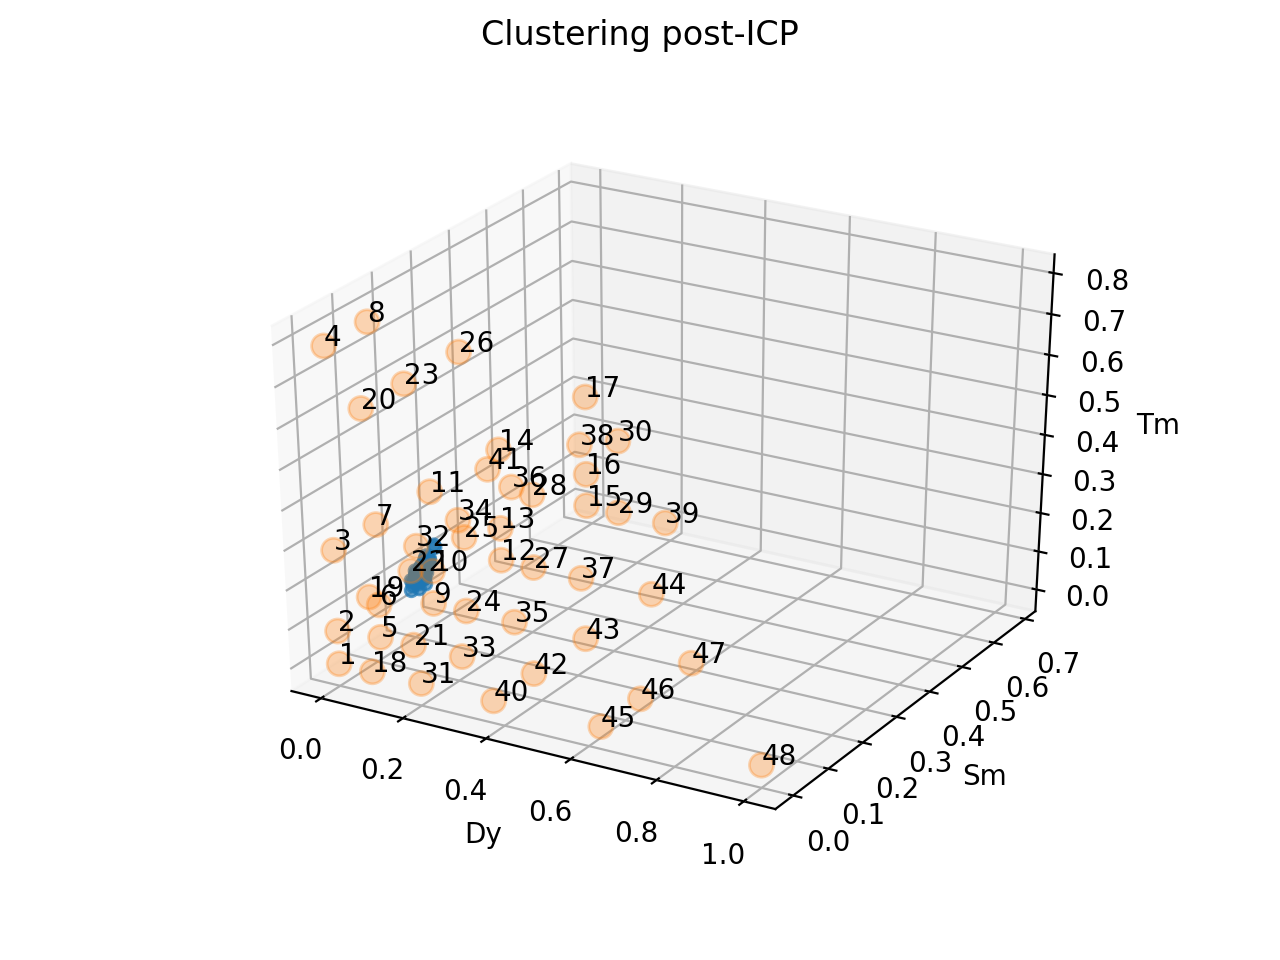

<IPython.core.display.Javascript object>


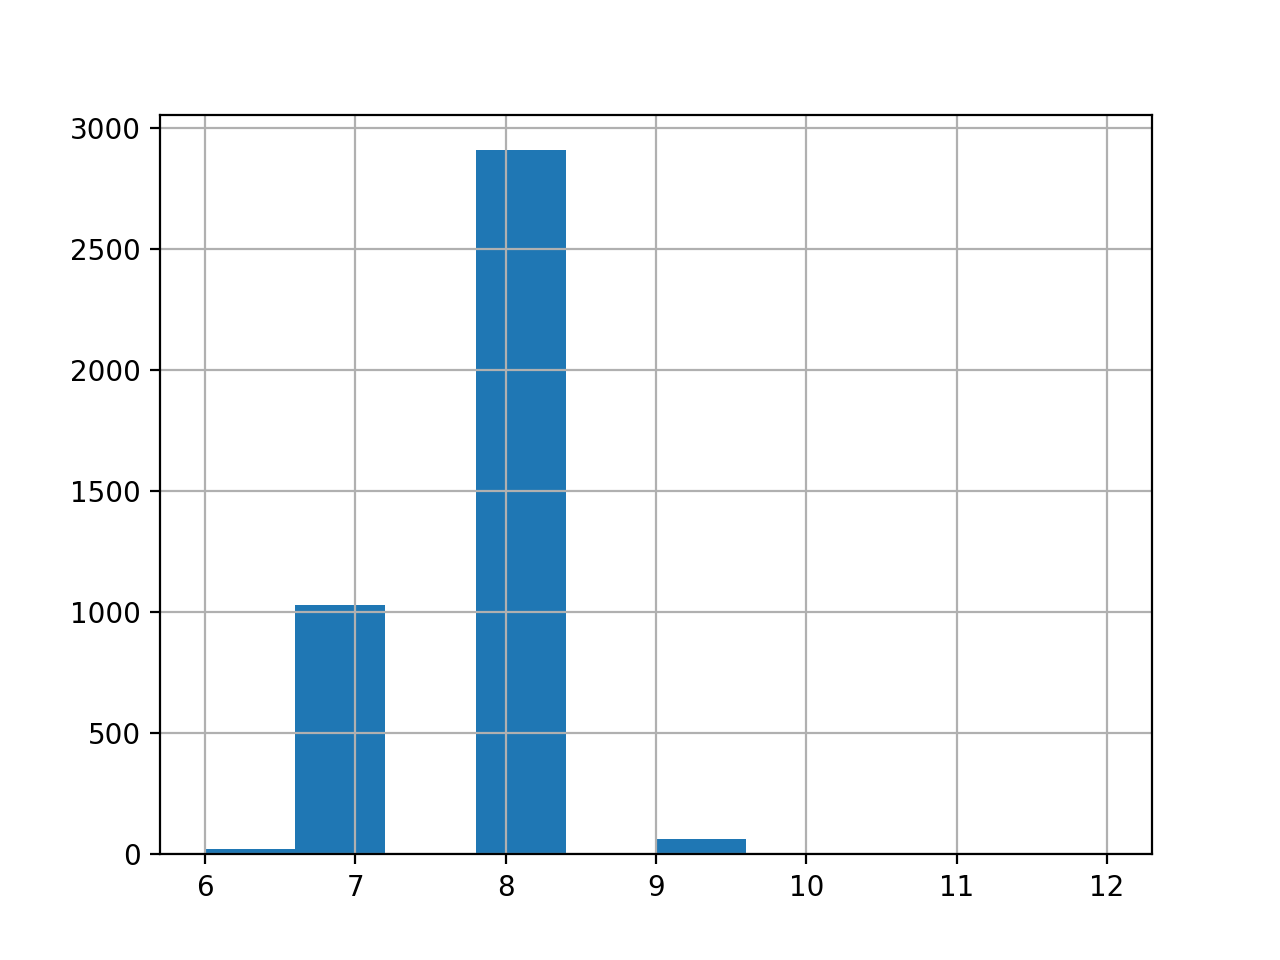

<IPython.core.display.Javascript object>


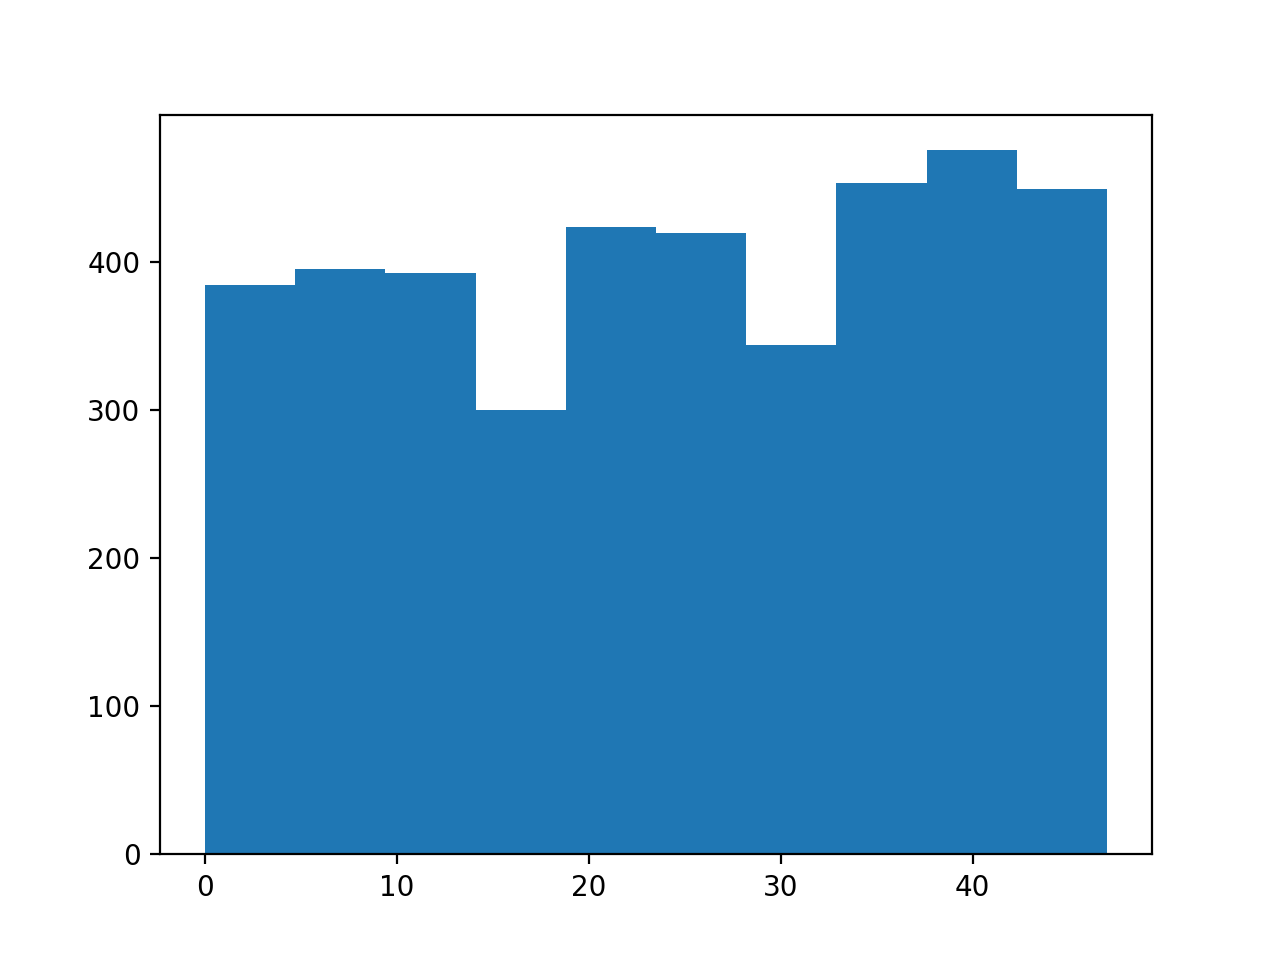

(array([ 384.,  395.,  392.,  300.,  423.,  419.,  344.,  453.,  475.,  449.]),
 array([  0. ,   4.7,   9.4,  14.1,  18.8,  23.5,  28.2,  32.9,  37.6,
         42.3,  47. ]),
 <a list of 10 Patch objects>)

In [12]:
# Clustering pre-ICP & Pre-filter
ba.inspect.Cluster.scatter(bead_set.loc[:, ('rat_dy', 'rat_sm', 'rat_tm')].values, 
                           target, 
                           title="Clustering pre-ICP & Pre-filter", 
                           axes_names=['Dy', 'Sm', 'Tm'])
# Clustering pre-ICP & Filtered
ba.inspect.Cluster.scatter(bead_set.loc[filter_all, ('rat_dy', 'rat_sm', 'rat_tm')].values, 
                           target, 
                           bead_set.loc[filter_all, ('code')].values, 
                           title="Clustering pre-ICP & Filtered", 
                           axes_names=['Dy', 'Sm', 'Tm'])
# Clustering post-ICP & Filtered
ba.inspect.Cluster.scatter(bead_set.loc[filter_all, ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')].values, 
                           target, 
                           bead_set.loc[filter_all, ('code')].values, 
                           title="Clustering post-ICP & Filtered", 
                           axes_names=['Dy', 'Sm', 'Tm'])
# Clustering post-ICP & Filtered & Confidence Filtered
ba.inspect.Cluster.scatter(bead_set.loc[(bead_set.confidence > 0), ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')].values, 
                           target, 
                           bead_set.loc[(bead_set.confidence > 0), ('code')].values, 
                           title="Clustering post-ICP & Filtered & Confidence Filtered", 
                           axes_names=['Dy', 'Sm', 'Tm'])

# Single code chart
code_no = 21 # Starts at 0!
code_data = np.vstack(bead_set.loc[(bead_set.code == code_no), ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')].as_matrix())
ba.inspect.Cluster.scatter(code_data, target, title="Clustering post-ICP", axes_names=['Dy', 'Sm', 'Tm'])

# Size dist
plt.figure()
bead_set.loc[filter_all, ('dim_r')].hist(bins=10)

# Beads per code distribution
plt.figure()
plt.hist(bead_set.loc[filter_all, ('code')])

## Scatter charts

In [13]:
confidence = 0
colors = np.multiply(bead_set.code.loc[(bead_set.confidence > confidence)].values, np.ceil(255/gmix._nclusters))

bead_ratios = go.Scatter3d(
    name='Bead ratios',
    x=bead_set.loc[(bead_set.confidence > confidence), ('rat_dy_icp')].values,
    y=bead_set.loc[(bead_set.confidence > confidence), ('rat_sm_icp')].values,
    z=bead_set.loc[(bead_set.confidence > confidence), ('rat_tm_icp')].values,
    text=bead_set.loc[(bead_set.confidence > confidence), ('code')].values,
    mode='markers',
    marker=dict(
        size=3,
        color=colors, 
        colorscale='Rainbow',
        opacity=0.6
    )
)

target_ratios = go.Scatter3d(
    name='Target ratios',
    x=target[:,0],
    y=target[:,1],
    z=target[:,2],
    text=range(gmix._nclusters),
    mode='markers',
    marker=dict(
        size=4,
        color='Black',
        opacity=0.5,
        symbol="diamond"
    )
)

mean_ratios = go.Scatter3d(
    name='GMM mean ratios',
    x=gmix.means[:,0],
    y=gmix.means[:,1],
    z=gmix.means[:,2],
    text=range(gmix._nclusters),
    mode='markers',
    marker=dict(
        size=4,
        color='Red',
        opacity=0.5,
        symbol="diamond"
    )
)

data = [bead_ratios, target_ratios, mean_ratios]
layout = go.Layout(
    showlegend=True,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')